In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from models import model, eval
import torch
from utils import dev
from torchvision import datasets, transforms
from sklearn import decomposition
from tqdm import tqdm

%matplotlib inline

# Universal Advs

In [3]:
# define funstions

def get_dist(orig, pert, model, delta=0.01, epsilons = np.linspace(-100,100,201)):
    orig = orig.reshape(784)
    unitary_pert = pert.reshape(784)/np.linalg.norm(pert.reshape(784))
    
    label = np.argmax(model(torch.tensor(np.reshape(orig, (1, 1, 28, 28)), device=dev())).detach().cpu().numpy())
    
    inputs = np.outer(epsilons,unitary_pert) + orig
    proj_inputs = np.clip(inputs,0,1)
    pred = model(torch.tensor(proj_inputs.astype('float32'), device=dev()).reshape(-1, 1, 28, 28)).detach().cpu().numpy()
    pred_classes = np.argmax(pred, axis=-1)

    if np.all(pred_classes==label):
        return np.nan
    
    changed = epsilons[pred_classes != label]
    min_epsilon_idx = np.argmin(abs(changed))
    idx = np.argwhere(epsilons==changed[min_epsilon_idx])

    
    # do a second search with more precise epsilon
    if epsilons[idx]>0:
        new_epsilons = np.linspace(epsilons[idx-1], epsilons[idx], np.maximum(int(1/delta),100))
    else: 
        new_epsilons = np.linspace(epsilons[idx+1], epsilons[idx], np.maximum(int(1/delta),100))
        
    inputs = np.outer(new_epsilons, unitary_pert) + orig
    proj_inputs = np.clip(inputs,0,1)
    
    pred = model(torch.tensor(proj_inputs.astype('float32'), device=dev()).reshape(-1, 1, 28, 28)).detach().cpu().numpy()
    pred_classes = np.argmax(pred, axis=-1)
    
    idx = np.min(np.argwhere(pred_classes != label))
        
    return np.linalg.norm(proj_inputs[idx]-orig)
    

def get_mean_dist(orig, model, n_sample_dirs=100, delta=0.01):
    dists = np.zeros(n_sample_dirs)
        
    # generate n random unitary vectors
    dirs = np.random.uniform(size=(n_sample_dirs,784)) - orig.reshape(784)
    
    for i, d in enumerate(dirs):
        dists[i] = get_dist(orig, d, model, delta, epsilons = np.linspace(0,100,101))
        
    mean_dist = np.nanmean(dists)
    
    return mean_dist

## Load data and models

In [4]:
# load data
data = np.load('data/cnn5.npy', allow_pickle=True).item()
advs = data['advs']
pert_lengths = data['pert_lengths']
classes = data['adv_class']
dirs = data['dirs']
images = data['images']
labels = data['labels']

In [5]:
# load models
model_natural = model.madry()
model_madry = model.madry()
model_natural.load_state_dict(torch.load('./models/natural.pt', map_location=torch.device(dev())))
model_madry.load_state_dict(torch.load('./models/adv_trained_l2.pt', map_location=torch.device(dev())))
model_natural.to(dev())
model_madry.to(dev())

madry(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
)

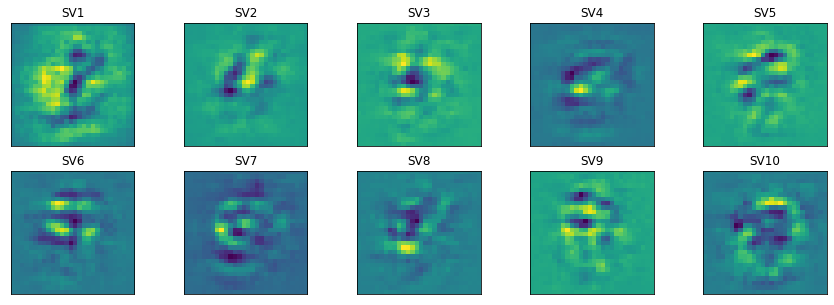

In [6]:
# extract singular values and vectors
M = (dirs)[:,0].reshape(-1,dirs[:,0].shape[-1])
u,s,v = np.linalg.svd(M)

# visualize first 10 singular vectors
plt.subplots(2,5,figsize=(15,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(v[i].reshape((28,28)))
    plt.xticks([])
    plt.yticks([])
    plt.title('SV' + str(i+1))

## Check how many random perturbation samples are needed for good estimate

Text(0.5, 1.0, 'mean distance to decision boundary of random direction for different sample rates')

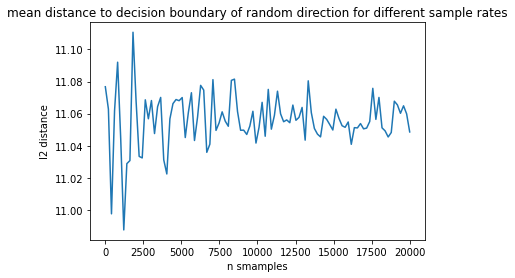

In [8]:
# # see when random length converges
# n_runs = 100
# n_samples = np.linspace(10,20000,n_runs)
# e_random = np.zeros(n_runs)
# for i,n in enumerate(tqdm(n_samples)):
# #     print('Estimating distance to decision boundary with %d random directions.' % (n))
#     e_random[i] = get_mean_dist(images[1], model_natural, int(n))
plt.plot(n_samples,e_random)
plt.xlabel('n smamples')
plt.ylabel('l2 distance')
plt.title('mean distance to decision boundary of random direction for different sample rates')

## Get distances for random directions on random images

In [29]:
n_images = 100
img_indices = np.arange(len(images))
np.random.shuffle(img_indices)
img_indices=img_indices[:n_images]
d_random= np.zeros(n_images)

for i, img in enumerate(tqdm(images[img_indices])):
    d_random[i] = get_mean_dist(img, model_natural, n_sample_dirs=500)
print('Mean length of random direction needed to reach decision boundary: %.2f' % (np.nanmean(d_random)))

100%|██████████| 100/100 [02:23<00:00,  1.44s/it]

Mean length of random direction needed to reach decision boundary: 10.34


## Get ratios for singular vectors 

In [30]:
n_singular_vectors = 784
d_svd = np.zeros((n_images, n_singular_vectors))

for i, img in enumerate(tqdm(images[img_indices])):
    for j in range(n_singular_vectors):
        d_svd[i,j] = get_dist(img, v[j], model_natural)

100%|██████████| 100/100 [04:43<00:00,  2.83s/it]


Text(0.5, 1.0, 'Ratio of singular vector and random direction l2 distance to decsion boundary')

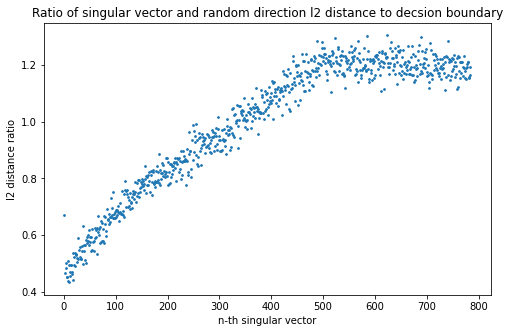

In [31]:
ratios_svd = np.nanmean(d_svd /d_random.reshape(-1,1),axis=0)
plt.figure(figsize=(8,5))
plt.scatter(np.arange(1,len(ratios_svd)+1),ratios_svd,s=3)
plt.xlabel('n-th singular vector')
plt.ylabel('l2 distance ratio')
plt.title('Ratio of singular vector and random direction l2 distance to decsion boundary')

## Get ratios of random perturbations and principal adversarial directions

In [32]:
# ratio of principle adversarials
d_adv=np.zeros((n_images,5))

for i, idx in enumerate(img_indices):
    for j,d in enumerate(dirs[idx]):
        d_adv[i,j] = get_dist(images[idx], dirs[idx,j], model_natural)

Text(0.5, 1.0, 'Ratio of random and principal adversarial direction l2 distance to decsion boundary')

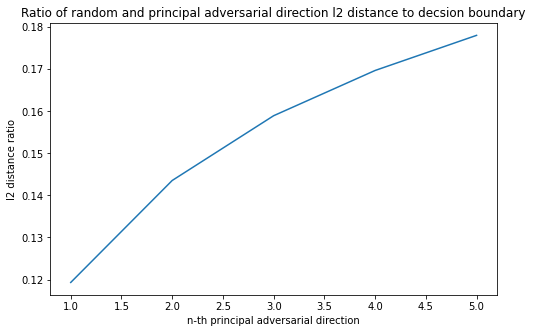

In [33]:
ratios_adv = np.nanmean(d_adv /d_random.reshape(-1,1),axis=0)
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,d_adv.shape[1]+1),ratios_adv)
plt.xlabel('n-th principal adversarial direction')
plt.ylabel('l2 distance ratio')
# plt.xticks(np.arange(1,d_svd.shape[1]+1,d_svd.shape[1]/10))
plt.title('Ratio of random and principal adversarial direction l2 distance to decsion boundary')

## Extract universal perturbations via code from https://paperswithcode.com/paper/universal-adversarial-perturbations

In [34]:

from UniversalPerturbations import adversarial_perturbation

trainset = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

testset = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=128)

net = model_natural

# universal_pert, fooling_rates, accuracies, total_iterations = adversarial_perturbation.generate(trainset, testset, net,delta=0.1, p=2, xi=5, max_iter_uni=30)

# plt.title("Fooling Rates over Universal Iterations")
# plt.xlabel("Universal Algorithm Iter")
# plt.ylabel("Fooling Rate on test data")
# plt.plot(np.arange(total_iterations+1),fooling_rates)
# plt.show()


# plt.title("Accuracy over Universal Iterations")
# plt.xlabel("Universal Algorithm Iter")
# plt.ylabel("Accuracy on Test data")
# plt.plot(np.arange(total_iterations+1), accuracies)
# plt.show()

# plt.imshow(universal_pert)
# plt.colorbar()
# plt.show()

Device: cuda:0
Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.0024
Iteration   2

FOOLING RATE:  0.0022
Iteration   3

FOOLING RATE:  0.0021
Iteration   4

FOOLING RATE:  0.0022
Iteration   5

FOOLING RATE:  0.0023
Iteration   6

FOOLING RATE:  0.0021
Iteration   7

FOOLING RATE:  0.0022
Iteration   8

FOOLING RATE:  0.0022
Iteration   9

FOOLING RATE:  0.0024
Iteration   10

FOOLING RATE:  0.0022
Iteration   11

FOOLING RATE:  0.002
Iteration   12

FOOLING RATE:  0.0021
Iteration   13

FOOLING RATE:  0.0021
Iteration   14

FOOLING RATE:  0.0023
Iteration   15

FOOLING RATE:  0.0022
Iteration   16

FOOLING RATE:  0.0022
Iteration   17

FOOLING RATE:  0.0022
Iteration   18

FOOLING RATE:  0.0022
Iteration   19

FOOLING RATE:  0.0022
Iteration   20

FOOLING RATE:  0.0024
Iteration   21

FOOLING RATE:  0.0022
Iteration   22

FOOLING RATE:  0.0022
Iteration   23

FOOLING RATE:  0.0022
Iteration   24

FOOLING RATE:  0.0022
Iteration   25

FOOLING RATE:  0.0021
Iteration   26



Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.0059
Iteration   2

FOOLING RATE:  0.005
Iteration   3

FOOLING RATE:  0.0069
Iteration   4

FOOLING RATE:  0.0059
Iteration   5

FOOLING RATE:  0.0056
Iteration   6

FOOLING RATE:  0.0059
Iteration   7

FOOLING RATE:  0.0062
Iteration   8

FOOLING RATE:  0.0056
Iteration   9

FOOLING RATE:  0.0061
Iteration   10

FOOLING RATE:  0.0062
Iteration   11

FOOLING RATE:  0.0055
Iteration   12

FOOLING RATE:  0.006
Iteration   13

FOOLING RATE:  0.0053
Iteration   14

FOOLING RATE:  0.0063
Iteration   15

FOOLING RATE:  0.0062
Iteration   16

FOOLING RATE:  0.0065
Iteration   17

FOOLING RATE:  0.0061
Iteration   18

FOOLING RATE:  0.0062
Iteration   19

FOOLING RATE:  0.0065
Iteration   20

FOOLING RATE:  0.0065
Iteration   21

FOOLING RATE:  0.0062
Iteration   22

FOOLING RATE:  0.0059
Iteration   23

FOOLING RATE:  0.0055
Iteration   24

FOOLING RATE:  0.0059
Iteration   25

FOOLING RATE:  0.0056
Iteration   26

FOOLING RATE:  0

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.0114
Iteration   2

FOOLING RATE:  0.0111
Iteration   3

FOOLING RATE:  0.0159
Iteration   4

FOOLING RATE:  0.0201
Iteration   5

FOOLING RATE:  0.0183
Iteration   6

FOOLING RATE:  0.0186
Iteration   7

FOOLING RATE:  0.019
Iteration   8

FOOLING RATE:  0.0133
Iteration   9

FOOLING RATE:  0.0132
Iteration   10

FOOLING RATE:  0.0179
Iteration   11

FOOLING RATE:  0.0164
Iteration   12

FOOLING RATE:  0.0154
Iteration   13

FOOLING RATE:  0.0195
Iteration   14

FOOLING RATE:  0.012
Iteration   15

FOOLING RATE:  0.0142
Iteration   16

FOOLING RATE:  0.013
Iteration   17

FOOLING RATE:  0.0172
Iteration   18

FOOLING RATE:  0.0135
Iteration   19

FOOLING RATE:  0.0163
Iteration   20

FOOLING RATE:  0.0164
Iteration   21

FOOLING RATE:  0.0148
Iteration   22

FOOLING RATE:  0.0159
Iteration   23

FOOLING RATE:  0.0172
Iteration   24

FOOLING RATE:  0.014
Iteration   25

FOOLING RATE:  0.0172
Iteration   26

FOOLING RATE:  0.0

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.1674
Iteration   2

FOOLING RATE:  0.1984
Iteration   3

FOOLING RATE:  0.1948
Iteration   4

FOOLING RATE:  0.1867
Iteration   5

FOOLING RATE:  0.197
Iteration   6

FOOLING RATE:  0.2049
Iteration   7

FOOLING RATE:  0.2132
Iteration   8

FOOLING RATE:  0.2012
Iteration   9

FOOLING RATE:  0.1971
Iteration   10

FOOLING RATE:  0.2041
Iteration   11

FOOLING RATE:  0.2238
Iteration   12

FOOLING RATE:  0.1998
Iteration   13

FOOLING RATE:  0.1947
Iteration   14

FOOLING RATE:  0.1966
Iteration   15

FOOLING RATE:  0.1981
Iteration   16

FOOLING RATE:  0.1968
Iteration   17

FOOLING RATE:  0.2026
Iteration   18

FOOLING RATE:  0.1978
Iteration   19

FOOLING RATE:  0.2002
Iteration   20

FOOLING RATE:  0.2055
Iteration   21

FOOLING RATE:  0.2089
Iteration   22

FOOLING RATE:  0.2104
Iteration   23

FOOLING RATE:  0.2096
Iteration   24

FOOLING RATE:  0.2029
Iteration   25

FOOLING RATE:  0.2045
Iteration   26

FOOLING RATE:  

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.2597
Iteration   2

FOOLING RATE:  0.3448
Iteration   3

FOOLING RATE:  0.3342
Iteration   4

FOOLING RATE:  0.3279
Iteration   5

FOOLING RATE:  0.3166
Iteration   6

FOOLING RATE:  0.3177
Iteration   7

FOOLING RATE:  0.3155
Iteration   8

FOOLING RATE:  0.3205
Iteration   9

FOOLING RATE:  0.3245
Iteration   10

FOOLING RATE:  0.3235
Iteration   11

FOOLING RATE:  0.3285
Iteration   12

FOOLING RATE:  0.3313
Iteration   13

FOOLING RATE:  0.3277
Iteration   14

FOOLING RATE:  0.3299
Iteration   15

FOOLING RATE:  0.3336
Iteration   16

FOOLING RATE:  0.3466
Iteration   17

FOOLING RATE:  0.3381
Iteration   18

FOOLING RATE:  0.3395
Iteration   19

FOOLING RATE:  0.339
Iteration   20

FOOLING RATE:  0.3432
Iteration   21

FOOLING RATE:  0.3427
Iteration   22

FOOLING RATE:  0.34
Iteration   23

FOOLING RATE:  0.3378
Iteration   24

FOOLING RATE:  0.3364
Iteration   25

FOOLING RATE:  0.347
Iteration   26

FOOLING RATE:  0.3

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.4223
Iteration   2

FOOLING RATE:  0.4838
Iteration   3

FOOLING RATE:  0.487
Iteration   4

FOOLING RATE:  0.5045
Iteration   5

FOOLING RATE:  0.5167
Iteration   6

FOOLING RATE:  0.5233
Iteration   7

FOOLING RATE:  0.5267
Iteration   8

FOOLING RATE:  0.5281
Iteration   9

FOOLING RATE:  0.5349
Iteration   10

FOOLING RATE:  0.5467
Iteration   11

FOOLING RATE:  0.5513
Iteration   12

FOOLING RATE:  0.5543
Iteration   13

FOOLING RATE:  0.5626
Iteration   14

FOOLING RATE:  0.5644
Iteration   15

FOOLING RATE:  0.5673
Iteration   16

FOOLING RATE:  0.5724
Iteration   17

FOOLING RATE:  0.5729
Iteration   18

FOOLING RATE:  0.5752
Iteration   19

FOOLING RATE:  0.5741
Iteration   20

FOOLING RATE:  0.5748
Iteration   21

FOOLING RATE:  0.5754
Iteration   22

FOOLING RATE:  0.5757
Iteration   23

FOOLING RATE:  0.5789
Iteration   24

FOOLING RATE:  0.577
Iteration   25

FOOLING RATE:  0.5761
Iteration   26

FOOLING RATE:  0

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.4607
Iteration   2

FOOLING RATE:  0.519
Iteration   3

FOOLING RATE:  0.5207
Iteration   4

FOOLING RATE:  0.5212
Iteration   5

FOOLING RATE:  0.5232
Iteration   6

FOOLING RATE:  0.5234
Iteration   7

FOOLING RATE:  0.5266
Iteration   8

FOOLING RATE:  0.534
Iteration   9

FOOLING RATE:  0.5314
Iteration   10

FOOLING RATE:  0.5289
Iteration   11

FOOLING RATE:  0.5341
Iteration   12

FOOLING RATE:  0.5379
Iteration   13

FOOLING RATE:  0.5395
Iteration   14

FOOLING RATE:  0.5416
Iteration   15

FOOLING RATE:  0.5433
Iteration   16

FOOLING RATE:  0.5413
Iteration   17

FOOLING RATE:  0.5413
Iteration   18

FOOLING RATE:  0.5409
Iteration   19

FOOLING RATE:  0.5419
Iteration   20

FOOLING RATE:  0.5427
Iteration   21

FOOLING RATE:  0.545
Iteration   22

FOOLING RATE:  0.5456
Iteration   23

FOOLING RATE:  0.5441
Iteration   24

FOOLING RATE:  0.5446
Iteration   25

FOOLING RATE:  0.5456
Iteration   26

FOOLING RATE:  0.

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.6572
Iteration   2

FOOLING RATE:  0.6697
Iteration   3

FOOLING RATE:  0.678
Iteration   4

FOOLING RATE:  0.6701
Iteration   5

FOOLING RATE:  0.6632
Iteration   6

FOOLING RATE:  0.6546
Iteration   7

FOOLING RATE:  0.6474
Iteration   8

FOOLING RATE:  0.6447
Iteration   9

FOOLING RATE:  0.641
Iteration   10

FOOLING RATE:  0.6395
Iteration   11

FOOLING RATE:  0.6362
Iteration   12

FOOLING RATE:  0.6334
Iteration   13

FOOLING RATE:  0.6315
Iteration   14

FOOLING RATE:  0.6309
Iteration   15

FOOLING RATE:  0.6301
Iteration   16

FOOLING RATE:  0.6279
Iteration   17

FOOLING RATE:  0.6276
Iteration   18

FOOLING RATE:  0.6264
Iteration   19

FOOLING RATE:  0.6253
Iteration   20

FOOLING RATE:  0.6241
Iteration   21

FOOLING RATE:  0.6243
Iteration   22

FOOLING RATE:  0.6234
Iteration   23

FOOLING RATE:  0.6231
Iteration   24

FOOLING RATE:  0.6227
Iteration   25

FOOLING RATE:  0.6229
Iteration   26

FOOLING RATE:  0

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.5946
Iteration   2

FOOLING RATE:  0.6226
Iteration   3

FOOLING RATE:  0.6353
Iteration   4

FOOLING RATE:  0.6417
Iteration   5

FOOLING RATE:  0.6494
Iteration   6

FOOLING RATE:  0.6546
Iteration   7

FOOLING RATE:  0.6583
Iteration   8

FOOLING RATE:  0.6622
Iteration   9

FOOLING RATE:  0.6656
Iteration   10

FOOLING RATE:  0.6683
Iteration   11

FOOLING RATE:  0.6706
Iteration   12

FOOLING RATE:  0.6726
Iteration   13

FOOLING RATE:  0.674
Iteration   14

FOOLING RATE:  0.6752
Iteration   15

FOOLING RATE:  0.6761
Iteration   16

FOOLING RATE:  0.6777
Iteration   17

FOOLING RATE:  0.6802
Iteration   18

FOOLING RATE:  0.681
Iteration   19

FOOLING RATE:  0.6813
Iteration   20

FOOLING RATE:  0.6816
Iteration   21

FOOLING RATE:  0.6824
Iteration   22

FOOLING RATE:  0.6834
Iteration   23

FOOLING RATE:  0.6839
Iteration   24

FOOLING RATE:  0.6841
Iteration   25

FOOLING RATE:  0.6848
Iteration   26

FOOLING RATE:  0

Clean model accuracy: 99.18%
Iteration   1

FOOLING RATE:  0.4783
Iteration   2

FOOLING RATE:  0.5619
Iteration   3

FOOLING RATE:  0.5973
Iteration   4

FOOLING RATE:  0.6149
Iteration   5

FOOLING RATE:  0.6323
Iteration   6

FOOLING RATE:  0.6474
Iteration   7

FOOLING RATE:  0.6585
Iteration   8

FOOLING RATE:  0.6654
Iteration   9

FOOLING RATE:  0.6742
Iteration   10

FOOLING RATE:  0.68
Iteration   11

FOOLING RATE:  0.6838
Iteration   12

FOOLING RATE:  0.6868
Iteration   13

FOOLING RATE:  0.6932
Iteration   14

FOOLING RATE:  0.6968
Iteration   15

FOOLING RATE:  0.7006
Iteration   16

FOOLING RATE:  0.7036
Iteration   17

FOOLING RATE:  0.707
Iteration   18

FOOLING RATE:  0.7089
Iteration   19

FOOLING RATE:  0.7109
Iteration   20

FOOLING RATE:  0.7123
Iteration   21

FOOLING RATE:  0.714
Iteration   22

FOOLING RATE:  0.7151
Iteration   23

FOOLING RATE:  0.7166
Iteration   24

FOOLING RATE:  0.7178
Iteration   25

FOOLING RATE:  0.7191
Iteration   26

FOOLING RATE:  0.7

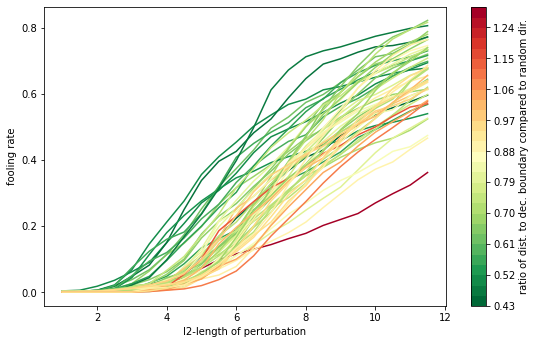

In [90]:
n_svds = 50
l2_norms = np.arange(1,12,0.5)
fooling_rates_universal = np.zeros(len(l2_norms))
fooling_rates_svd = np.zeros((n_svds,len(l2_norms)))
universal_perts = np.zeros((len(l2_norms),28,28))

for i, norm in enumerate(l2_norms):
    for j in range(3):
        universal_pert, fooling_rates, accuracies, total_iterations=adversarial_perturbation.generate(trainset, testset, net, delta=0.1, p=2, xi=norm, max_iter_uni=30)
        universal_perts[i] = universal_pert

        proj_inputs = np.clip(images + universal_pert, 0, 1)
        pred = model_natural(torch.tensor(proj_inputs.astype('float32'), device=dev()).reshape(-1, 1, 28, 28)).detach().cpu().numpy()
        new_labels = np.argmax(pred, axis=-1)

        fooling_rates_universal[i] += (new_labels != labels).sum()/len(labels)
    fooling_rates_universal[i]/=3
    for j in range(n_svds):
        proj_inputs = np.clip(images + norm*v[j].reshape((28,28)), 0, 1)
        pred = model_natural(torch.tensor(proj_inputs.astype('float32'), device=dev()).reshape(-1, 1, 28, 28)).detach().cpu().numpy()
        new_labels = np.argmax(pred, axis=-1)
        fooling_rates_svd[j,i] = (new_labels != labels).sum()/len(labels)      
    

cmap = plt.get_cmap('RdYlGn') 
fig = plt.figure(figsize=(9,5.5))
# plt.plot(l2_norms,fooling_rates_universal,'k--', linewidth=3)
for i, fr in enumerate(fooling_rates_svd):
    relative_ratio = (ratios_svd[i]-ratios_svd[:n_svds].min())/(ratios_svd[:n_svds].max()-ratios_svd[:n_svds].min())
    color = np.clip(relative_ratio,0,0.999)
    plt.plot(l2_norms, fr, c=cmap(1-relative_ratio))
plt.xlabel('l2-length of perturbation')
plt.ylabel('fooling rate')
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar=plt.colorbar(sm, format='%.2f', label='ratio of dist. to dec. boundary compared to random dir.', boundaries=np.linspace(ratios_svd.min(),ratios_svd.max(),30), values=np.linspace(ratios_svd.max(),ratios_svd.min(),29))


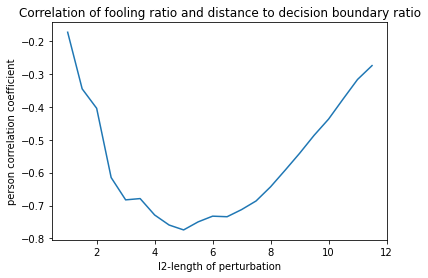

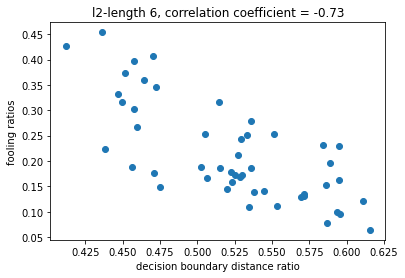

In [103]:
# make plot correlating fooling rate and decisin boundary distance
x = ratios_svd[1:n_svds]
Y = fooling_rates_svd[1:]
r = np.zeros(len(l2_norms))

for i in range(len(l2_norms)):
    y = Y[:,i]

    r[i], _ = sp.stats.pearsonr(x,y)
plt.plot(l2_norms,r)
plt.xlabel('l2-length of perturbation')
plt.ylabel('person correlation coefficient')
plt.title('Correlation of fooling ratio and distance to decision boundary ratio')
plt.show()


idx=np.argwhere(l2_norms==6)
plt.scatter(x,Y[:,idx])
plt.xlabel('decision boundary distance ratio')
plt.ylabel('fooling ratios')
plt.title('l2-length 6, correlation coefficient = %.2f' % (r[idx]))
plt.show()


In [ ]:
plt.plot(l2_norms,fooling_rates_universal,'k--', linewidth=3)
for i, fr in enumerate(fooling_rates_svd):
    if i ==0:
        continue
    relative_ratio = (ratios_svd[i]-ratios_svd[1:n_svds].min())/(ratios_svd[1:n_svds].max()-ratios_svd[1:n_svds].min())
    color = np.clip(np.array([2*relative_ratio,2*(1-relative_ratio),0]),0,0.8)
    plt.plot(l2_norms, fr, c=color)
plt.xlabel('l2-length of perturbation')
plt.ylabel('fooling rate')

In [ ]:
# ratio of universal perturbations
d_uni = np.zeros((n_images,len(universal_perts)))

for i, img in enumerate(images[img_indices]):
    for j, u in enumerate(universal_perts):
        d_uni[i,j] = get_dist(img, u, model_natural)
    print('%.2f%% done!' % ((i+1)/n_images*100))
ratios = np.nanmean(d_uni/d_random.reshape(-1,1), axis=0)
print(ratios)
np.nanmean(ratios)